# CNN을 활용한 상품 카테고리 분류

## 1. 데이터 전처리

### 1.1 필요한 라이브러리 임포트

In [1]:
import os
import shutil
import pandas as pd
import re

### 1.2 레이블 전처리 함수 정의

In [2]:
def preprocess_label(label):
    
    # 대체 문자 처리
    label = label.replace(' & ', '-')
    label = label.replace(' ', '-')
    label = label.replace('/', '-')

    # 소문자 변환
    label = label.lower()
    # 특수 문자 제거
    label = re.sub(r'[^a-zA-Z0-9-]', '', label)

    return label

### 1.3 데이터 로드 및 전처리

In [3]:
df = pd.read_csv('./articles.csv')

#파일명으로 저장하기 적합하게 카테고리명 전처리
df['product_group_name'] = df['product_group_name'].apply(preprocess_label)

### 1.4 이미지 파일 이동 및 정리

In [4]:
# 이미지 그룹별로 이미지 저장하기
no_img =  0
for index, row in df.iterrows():
    try:
        image_group = row['product_group_name']
        image_name = str(row['article_id']).zfill(10)  # 'article_id'를 문자열로 처리
        img_slice = image_name[:3]

        # 이미지 그룹 이름으로 폴더 생성 (이미 존재하지 않는 경우에만)
        if not os.path.exists(f'imagedata/{image_group}'):
            os.makedirs(f'imagedata/{image_group}')

        # 이미지 원본 경로
        source_path = f'images/{img_slice}/{image_name}.jpg'

        # 이미지 목적지 경로
        destination_path = f'imagedata/{image_group}/{image_name}.jpg'

        # 이미지 파일 이동
        shutil.move(source_path, destination_path)
    except:
        #print(image_name)
        no_img += 1

print(f'no img = {no_img}')

no img = 442


## 2. 이미지 훈련 준비

### 2.1 필요한 라이브러리 임포트

In [5]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pickle

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

2024-09-10 16:20:21.265071: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 16:20:21.265236: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 16:20:21.265536: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 16:20:21.449297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 16:20:23.184298: W tensorflow/compiler/

### 2.2 이미지 데이터 로드 및 전처리

In [6]:
dir_ = Path('imagedata')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
# 데이터 확인
df.head(5)

Filepath               Label
0  imagedata/garment-upper-body/0583786004.jpg  garment-upper-body
1  imagedata/garment-upper-body/0923569007.jpg  garment-upper-body
2   imagedata/garment-full-body/0742455002.jpg   garment-full-body
3            imagedata/swimwear/0688537004.jpg            swimwear
4         imagedata/accessories/0633670001.jpg         accessories

### 2.3 데이터 탐색

In [7]:
num_label = len(df.Label.unique())
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {num_label}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 105100

Number of different labels: 19

Labels: ['garment-upper-body' 'garment-full-body' 'swimwear' 'accessories'
 'garment-lower-body' 'shoes' 'socks-tights' 'underwear' 'nightwear'
 'underwear-nightwear' 'garment-and-shoe-care' 'furniture' 'cosmetic'
 'unknown' 'items' 'bags' 'fun' 'interior-textile' 'stationery']


### 2.4 이미지 시각화

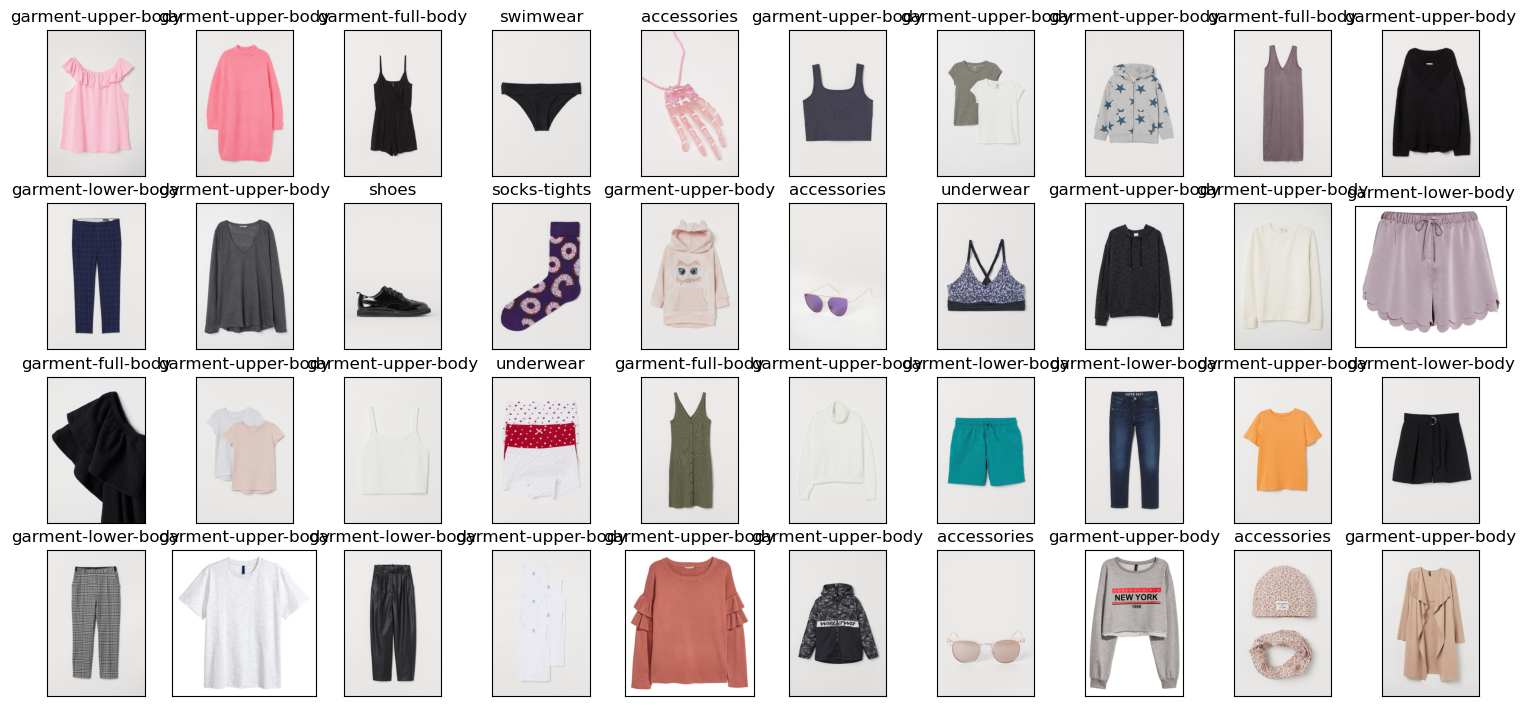

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

### 2.5 카테고리 분포 시각화

/tmp/ipykernel_291308/3958523583.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = vc.index, x = vc, palette = "rocket", orient = 'h')


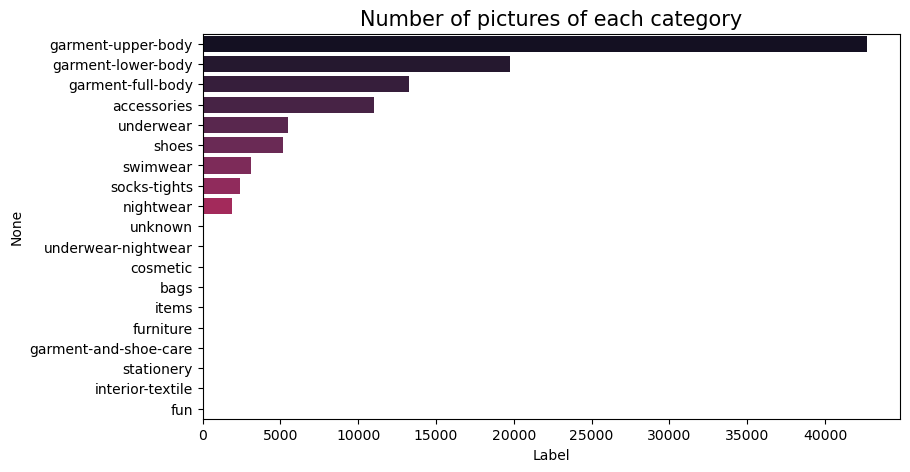

In [9]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(y = vc.index, x = vc, palette = "rocket", orient = 'h')
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

## 3. 모델 훈련
*출처: https://zeuskwon-ds.tistory.com/49

### 3.1 데이터 분할

In [10]:
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((94590, 2), (10510, 2))

### 3.2 데이터 제너레이터 생성

In [11]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

### 3.3 모델 정의 및 훈련

In [12]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
train_generator,test_generator,train_images,val_images,test_images=create_gen()


def get_model(model):
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False 
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(num_label, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 모델 훈련 
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 85131 validated image filenames belonging to 19 classes.
Found 9459 validated image filenames belonging to 19 classes.
Found 10510 validated image filenames belonging to 16 classes.


2024-09-10 16:20:34.159372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-10 16:20:34.522015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-10 16:20:34.522107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-10 16:20:34.525839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-10 16:20:34.525951: I tensorflow/compile

DenseNet121          trained in 1550.83 sec
MobileNetV2          trained in 1490.45 sec
DenseNet201          trained in 1578.08 sec
EfficientNetB0       trained in 1606.41 sec
EfficientNetB1       trained in 1562.76 sec
InceptionV3          trained in 1497.5 sec
MobileNetV3Large     trained in 1508.71 sec
ResNet152V2          trained in 1495.41 sec
ResNet50             trained in 1480.0 sec
ResNet50V2           trained in 1491.87 sec
VGG19                trained in 1498.22 sec
VGG16                trained in 1496.6 sec
Xception             trained in 1500.71 sec


### 3.4 모델 성능 평가

In [13]:
# test데이터로 모델 성능 예측
for name, model in models.items():

    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
   
# 결과를 DataFrame으로 정리
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

329/329 [==============================] - 190s 574ms/step
**DenseNet121 has a 88.65% accuracy on the test set**
329/329 [==============================] - 179s 542ms/step
**MobileNetV2 has a 88.41% accuracy on the test set**
329/329 [==============================] - 175s 526ms/step
**DenseNet201 has a 89.06% accuracy on the test set**
329/329 [==============================] - 173s 524ms/step
**EfficientNetB0 has a 45.15% accuracy on the test set**
329/329 [==============================] - 173s 522ms/step
**EfficientNetB1 has a 47.77% accuracy on the test set**
329/329 [==============================] - 174s 528ms/step
**InceptionV3 has a 86.28% accuracy on the test set**
329/329 [==============================] - 172s 521ms/step
**MobileNetV3Large has a 71.33% accuracy on the test set**
329/329 [==============================] - 176s 530ms/step
**ResNet152V2 has a 89.51% accuracy on the test set**
329/329 [==============================] - 173s 526ms/step
**ResNet50 has a 72.06% ac

model  val_accuracy  accuracy  Training time (sec)
0         ResNet50V2        0.8922    0.8956              1491.87
1        ResNet152V2        0.8971    0.8951              1495.41
2        DenseNet201        0.8934    0.8906              1578.08
3        DenseNet121        0.8839    0.8865              1550.83
4        MobileNetV2        0.8837    0.8841              1490.45
5           Xception        0.8673    0.8714              1500.71
6        InceptionV3        0.8644    0.8628              1497.50
7              VGG16        0.8631    0.8621              1496.60
8              VGG19        0.8429    0.8479              1498.22
9           ResNet50        0.7159    0.7206              1480.00
10  MobileNetV3Large        0.7154    0.7133              1508.71
11    EfficientNetB1        0.4767    0.4777              1562.76
12    EfficientNetB0        0.4542    0.4515              1606.41

### 3.5 모델 성능 시각화

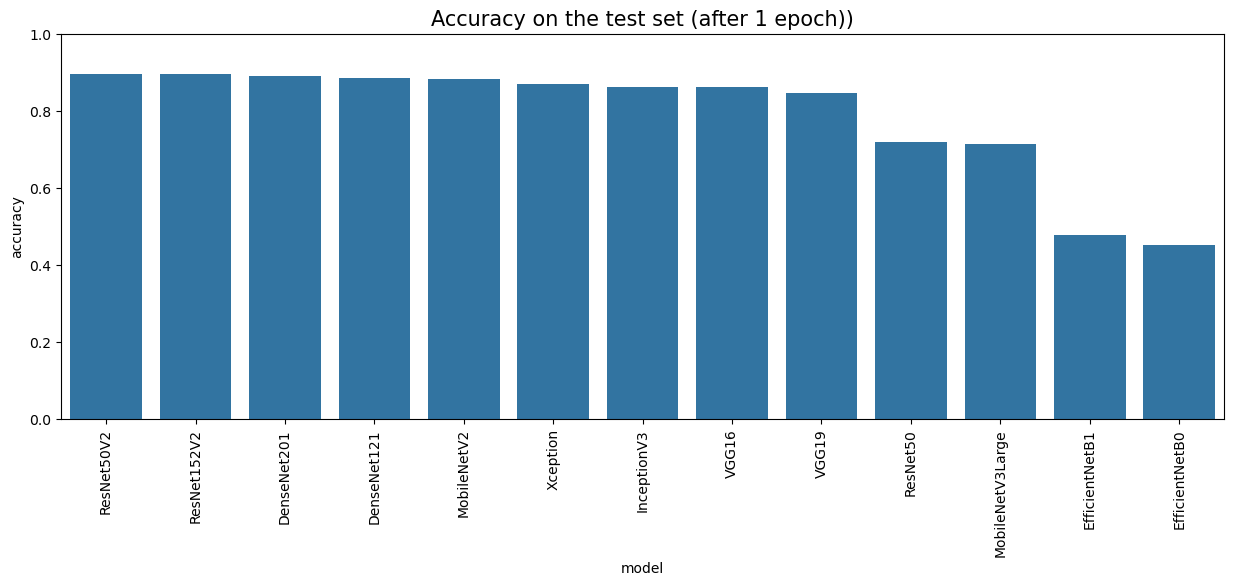

In [14]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

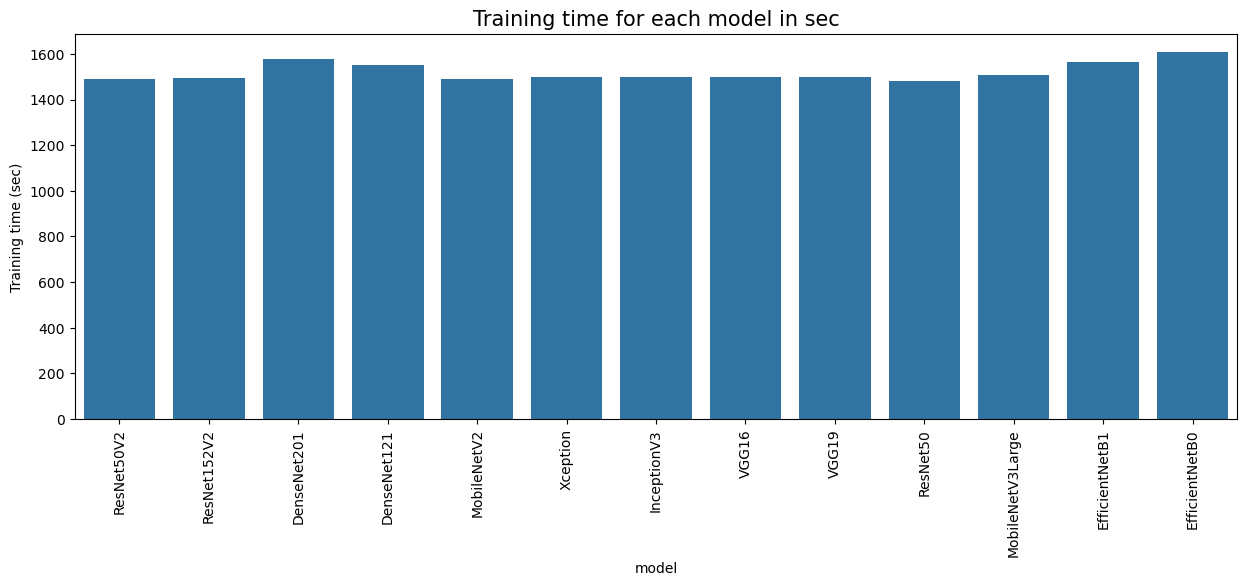

In [15]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

### 3.6 최종 모델 선택 및 추가 훈련

성능이 가장 좋다 예측되는 DenseNet201을 선택

In [16]:

train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 85131 validated image filenames belonging to 19 classes.
Found 9459 validated image filenames belonging to 19 classes.
Found 10510 validated image filenames belonging to 16 classes.
Epoch 1/7
2661/2661 [==============================] - 1583s 593ms/step - loss: 0.4016 - accuracy: 0.8745 - val_loss: 0.3227 - val_accuracy: 0.9001
Epoch 2/7
2661/2661 [==============================] - 1611s 606ms/step - loss: 0.2947 - accuracy: 0.9055 - val_loss: 0.2993 - val_accuracy: 0.9059
Epoch 3/7
2661/2661 [==============================] - 1528s 574ms/step - loss: 0.2572 - accuracy: 0.9166 - val_loss: 0.3097 - val_accuracy: 0.9007
Epoch 4/7
2661/2661 [==============================] - 1528s 574ms/step - loss: 0.2281 - accuracy: 0.9263 - val_loss: 0.2848 - val_accuracy: 0.9125
Epoch 5/7
2661/2661 [==============================] - 1531s 575ms/step - loss: 0.2065 - accuracy: 0.9320 - val_loss: 0.2819 - val_accuracy: 0.9135
Epoch 6/7
2661/2661 [==============================] - 1529s 575ms/step 

### 3.7 훈련 과정 시각화

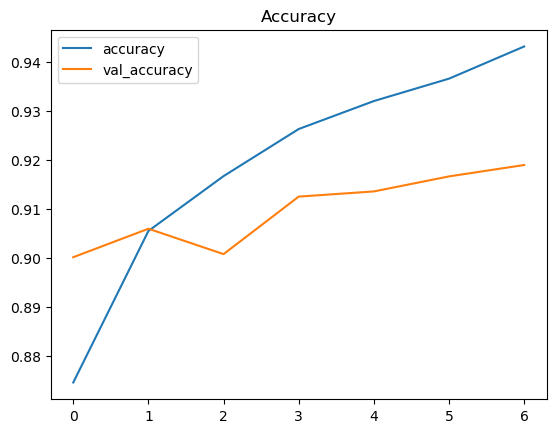

In [17]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

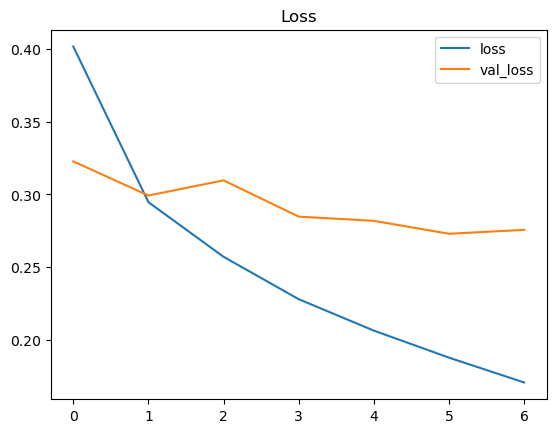

In [18]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

### 3.8 최종 모델 평가

In [19]:

pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)


labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

329/329 [==============================] - 196s 590ms/step
Accuracy on the test set: 91.70%


### 3.9 모델 저장

In [20]:
model.save('saved_model/')

with open('saved_model/class_indices.pkl', 'wb') as f:
    pickle.dump(train_images.class_indices, f)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


## 4. 모델 사용 및 예측

### 4.1 개별 이미지 예측

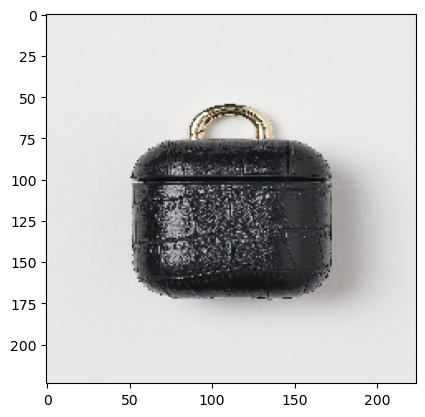

1/1 [==============================] - 3s 3s/step
예측 클래스: accessories
예측 확률: 100.00%

상위 3개 예측 결과:
accessories: 100.00%
bags: 0.00%
shoes: 0.00%


In [22]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

IMAGE_SIZE    = (224, 224)

# 데이터 탐색 부분에서 클래스 정보 생성
class_indices = train_images.class_indices
class_names = list(class_indices.keys())

# 예측 부분
number_1 = 5  # 예측할 이미지 인덱스
test_image = image.load_img(test_df.iloc[number_1, 0], target_size=IMAGE_SIZE)
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.)
plt.show()

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

# 예측 결과 처리
pred_class_index = np.argmax(prediction[0])
pred_class_name = class_names[pred_class_index]
pred_probability = prediction[0][pred_class_index]

print(f"예측 클래스: {pred_class_name}")
print(f"예측 확률: {pred_probability * 100:.2f}%")

# 상위 3개 예측 결과 출력
top_3_indices = prediction[0].argsort()[-3:][::-1]
print("\n상위 3개 예측 결과:")
for i in top_3_indices:
    print(f"{class_names[i]}: {prediction[0][i] * 100:.2f}%")
    

### 4.2 여러 이미지 예측 결과 시각화

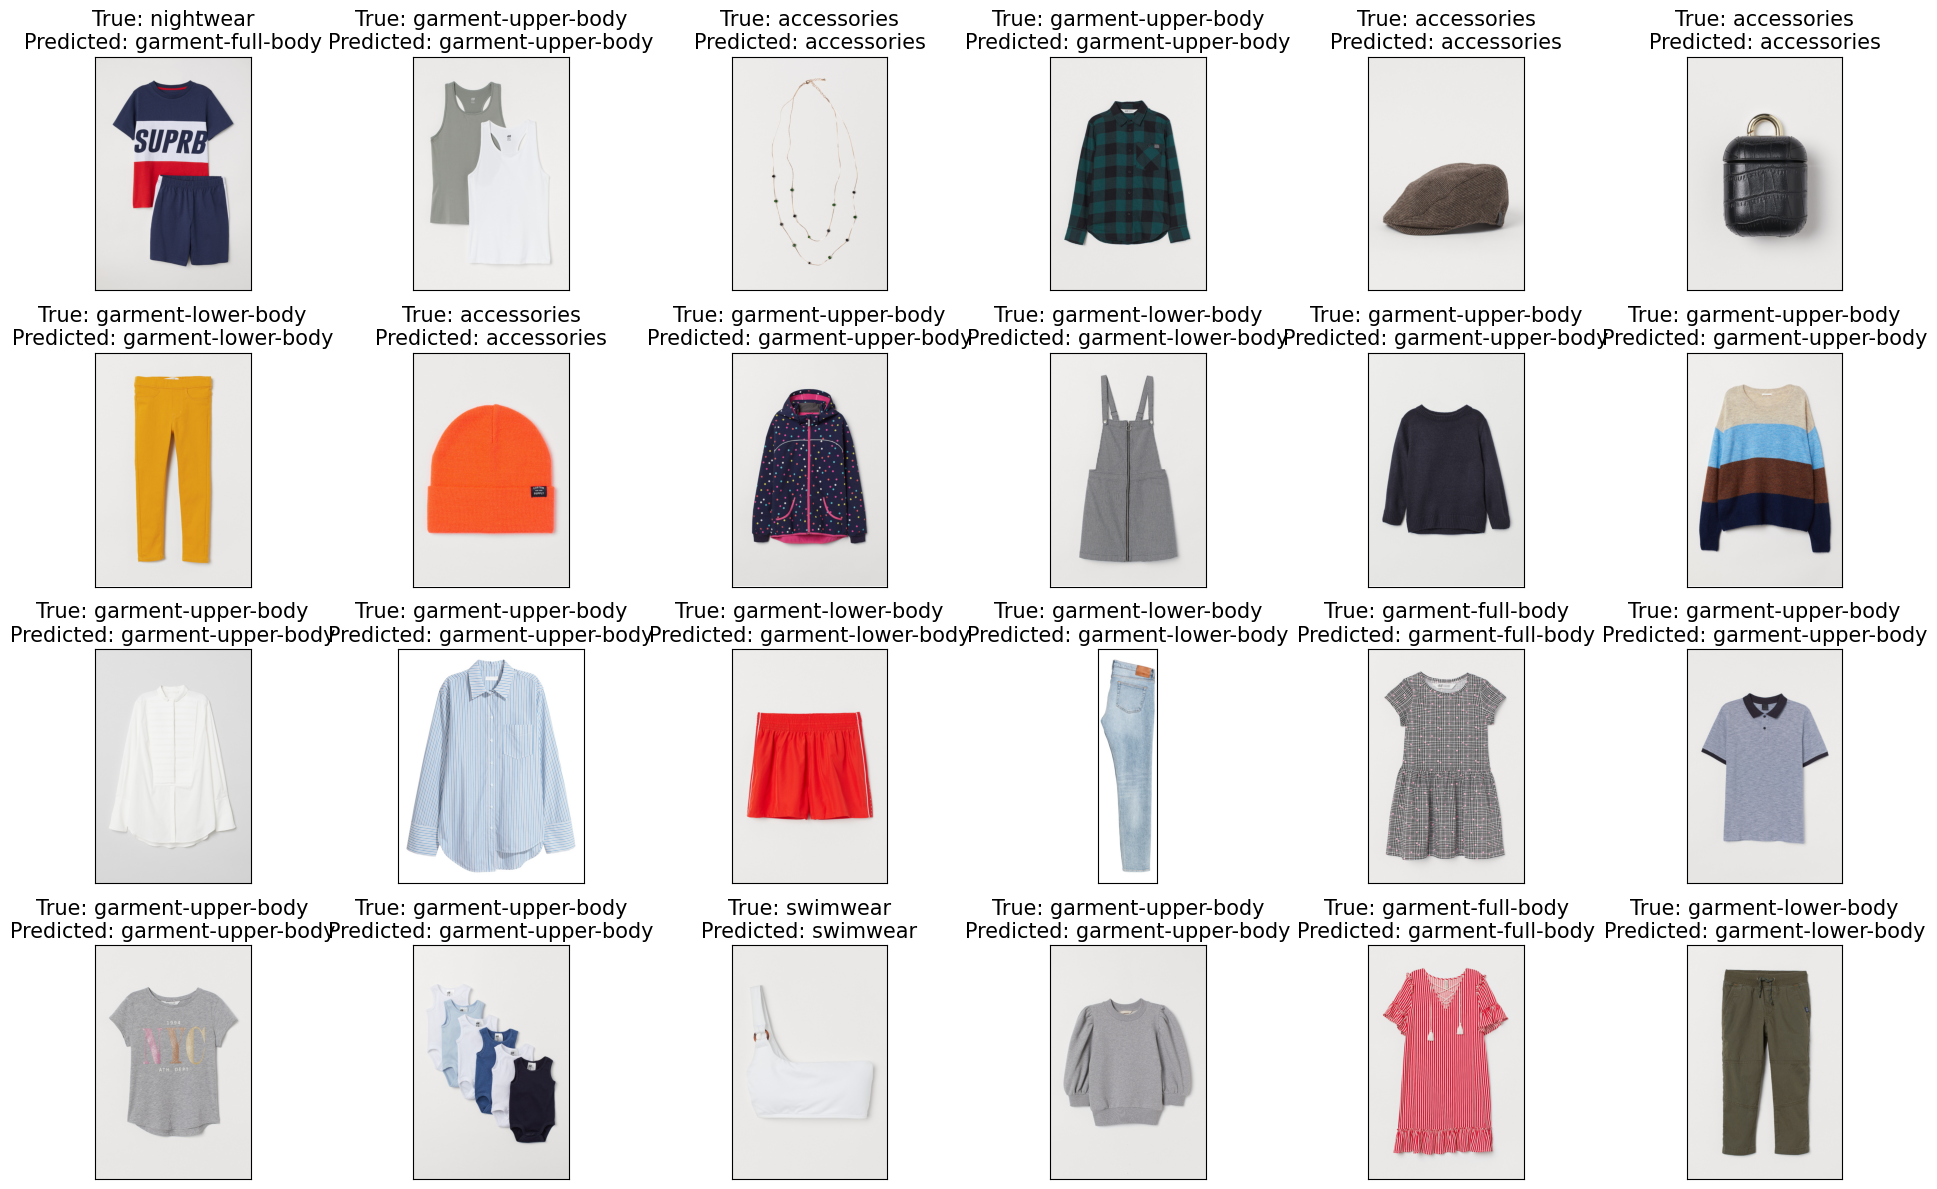

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

## 5. 새로운 이미지 분류

### 5.1 모델 로드 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import glob
import shutil
import tensorflow as tf


from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

IMAGE_SIZE    = (224, 224)

In [25]:
new_model = tf.keras.models.load_model('saved_model/')

In [26]:
with open('saved_model/class_indices.pkl', 'rb') as f:
    class_indices = pickle.load(f)

# 인덱스를 레이블로 변환
# class_indices 딕셔너리의 키와 값의 자리를 바꿔주는 과정
class_indices = {v: k for k, v in class_indices.items()}

In [27]:
# 모델확인
new_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_14[0][0]']            
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']   

### 5.2 새 이미지 분류 및 이동

In [28]:
# 폴더 경로
folder_path = 'imagedata/'

# .jpg 파일들의 경로 불러오기
image_files = glob.glob(os.path.join(folder_path, '**/*.jpg'), recursive=True)



# 각 이미지에 대해 예측 수행
for image_file in image_files:
    test_image = image.load_img(image_file, target_size=IMAGE_SIZE)
    test_image = image.img_to_array(test_image)
    test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
    test_image = preprocess_input(test_image)
    
    predictions = new_model.predict(test_image)

    # 가장 높은 확률을 가진 클래스 인덱스 찾기
    predicted_class_index = np.argmax(predictions)

    # 예측된 클래스 레이블
    predicted_class_label = class_indices[predicted_class_index]
    
    # 결과 출력
    #print(f'Image: {image_file} - Predicted class: {predicted_class_label}')

    base_name = os.path.basename(image_file)
    image_name = os.path.splitext(base_name)[0]
    #print(image_name)

    id_slice = image_name[:3]
    # 이미지 그룹 이름으로 폴더 생성 (이미 존재하지 않는 경우에만)
    if not os.path.exists(f'part_images/{id_slice}/{predicted_class_label}'):
        os.makedirs(f'part_images/{id_slice}/{predicted_class_label}')

    # 이미지 원본 경로
    source_path = image_file

    # 이미지 목적지 경로
    destination_path = f'part_images/{id_slice}/{predicted_class_label}/{image_name}.jpg'

    # 이미지 파일 이동
    shutil.move(source_path, destination_path)

1/1 [==============================] - 0s 52ms/step
1/1 [=9============================] - 0s 55ms/step
1/1 [==============================] - 0s 42ms/step
1/1 [=9============================] - 0s 45ms/step
1/1 [==============================] - 0s 38ms/step
